In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from othello.OthelloGame import OthelloGame as Game
from othello.OthelloGame import display as displayGame

import numpy as np

In [3]:
from othello_viz import display_board, plot_episode

In [4]:
def random_player(game, board):
    valid_modes = game.getValidMoves(board, 1)
    valid_moves_idxs = np.where(valid_modes == 1)[0]
    action = np.random.choice(valid_moves_idxs)
    return action

def greedy_player(game, board):
    valids = np.array(game.getValidMoves(board, 1))
    scores = []
    indexes = []
    for a in np.where(valids == 1)[0]:
        nextBoard, _ = game.getNextState(board, 1, a)
        score = game.getScore(nextBoard, 1)
        scores.append(score)
        indexes.append(a)
    scores_indxs = np.where(np.array(scores) == max(scores))[0]    
    return indexes[np.random.choice(scores_indxs)]

In [234]:
def play_episode(players, game, board, return_actions=False, append_last=False):
    # No necesita el jugador que comienza por que se resuelve en su forma canonica. 
    # Se ve el juego en la perspectiva de blanco siempre
    # board = game.getCanonicalForm(board, 1)
    states = []
    actions = []
    rewards = []
    player_turn = 0
    ended = game.getGameEnded(board, 1) 
    while ended == 0:
        states.append(board)
        action = players[player_turn](game, board)
        actions.append(action)
        board, _ = game.getNextState(board, 1, action)
        board = game.getCanonicalForm(board, -1)
        player_turn = (player_turn + 1) % len(players)
        ended = game.getGameEnded(board, 1) 
        if ended==0:
            rewards.append(0)
        else:
            rewards.append(np.sign(board.sum()))
    if append_last:
        states.append(board)
    if return_actions:
        return states, actions, rewards
    else:
        return states

In [235]:
# Defino juego
n = 4
game = Game(n)
board = game.getInitBoard()

In [236]:
player = 1 # or -1
game.getCanonicalForm(board, player)

array([[ 0,  0,  0,  0],
       [ 0, -1,  1,  0],
       [ 0,  1, -1,  0],
       [ 0,  0,  0,  0]])

In [237]:
import numpy as np
optimum_policy = np.load('pi_func_only_winner.npy', allow_pickle=True).item()
optimum_V = np.load('Value_func_only_winner.npy', allow_pickle=True).item()

In [238]:
board = np.array([[ -1,  -1,  -1,  -1],
       [ -1, -1,  -1,  -1],
       [ -1,  -1, -1,  -1],
       [ 0,  -1,  1,  1]])

In [239]:
board = game.getInitBoard()

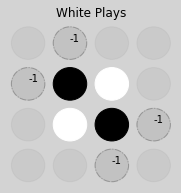

In [240]:
player = 1
display_board(game, board, player, valid_moves=game.getValidMoves(board, player), value_func=optimum_V)

In [241]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards = play_episode([random_player, greedy_player], game, board*player, return_actions=True)
print('longitud episodio:', len(states))

longitud episodio: 12


In [242]:
len(actions), len(states), len(rewards)

(12, 12, 12)

In [243]:
rewards

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

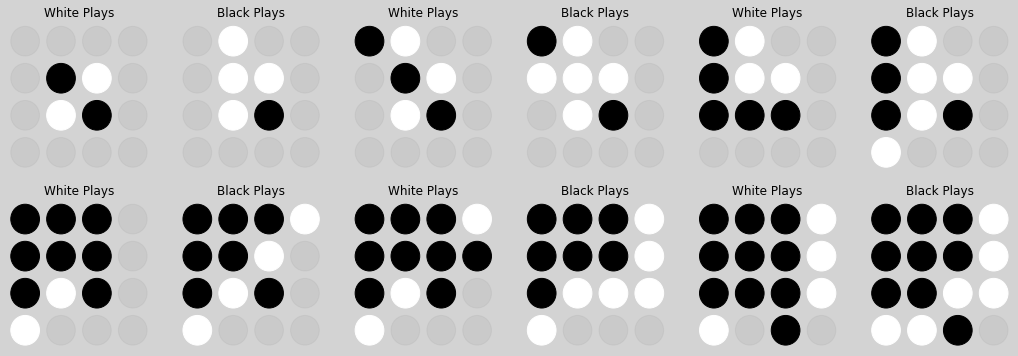

In [244]:
# Grafico episodio
plot_episode(game, states, initial_player = player)

# preguntas:
- Cuanto esperaria que sea la longitud de cada episodio siempre? (tener en cuenta el numero de espacios libres): 12
- Cuanto suele ser y por que?: mayor a 12
- Puede ser menos que 12? si, cuando ninguno puede mover mas

# Pruebas con Greedy y Random players

In [40]:
n = 4
game = Game(n)
board = game.getInitBoard()

In [41]:
from playing_stats import EvaluatePolicy
evalPolicy = EvaluatePolicy(None)

## Random vs Random

In [42]:
def display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces):
    print('player_1 wins:', str(int(100*player_1_wins/episodes + 0.5)) + '%')
    print('player_2 wins:', str(int(100*player_2_wins/episodes + 0.5)) +'%')
    print('ties:', str(int(100*ties/episodes + 0.5))+ '%')
    print('Max, Mean, Min margins: ', end ='')
    print(np.max(margins), np.mean(margins), np.min(margins))
    print('Max, Mean, Min steps: ', end ='')
    print(np.max(steps_array), np.mean(steps_array), np.min(steps_array))
    print('Max, Mean, Min pieces: ', end ='')
    print(np.max(pieces), np.mean(pieces), np.min(pieces))

In [43]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.random_player, -1: evalPolicy.random_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 37%
player_2 wins: 52%
ties: 11%
Max, Mean, Min margins: 16 -1.317 -16
Max, Mean, Min steps: 16 12.505 7
Max, Mean, Min pieces: 16 15.783 10


## Random vs Greedy
### El greedy juega primero

In [19]:
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.greedy_player, -1: evalPolicy.random_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 35%
player_2 wins: 53%
ties: 12%
Max, Mean, Min margins: 15 -1.441 -16
Max, Mean, Min steps: 16 12.56 7
Max, Mean, Min pieces: 16 15.701 10


### El greedy juega segundo

In [20]:
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.random_player, -1: evalPolicy.greedy_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 38%
player_2 wins: 53%
ties: 8%
Max, Mean, Min margins: 16 -1.048 -16
Max, Mean, Min steps: 17 12.418 7
Max, Mean, Min pieces: 16 15.632 10


Notar que el greedy no es mucho mejor que jugar random

# Greedy vs Greedy

In [21]:
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.greedy_player, -1: evalPolicy.greedy_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 45%
player_2 wins: 47%
ties: 8%
Max, Mean, Min margins: 15 -0.185 -16
Max, Mean, Min steps: 15 12.218 7
Max, Mean, Min pieces: 16 15.509 10


El segundo siempre suele ganar